In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [42]:
import warnings
warnings.filterwarnings("ignore")

## Super resolution data

In [6]:
from fastai.conv_learner import *
from pathlib import Path

In [7]:
torch.cuda.set_device(0)
torch.backends.cudnn.bechmark=True

In [8]:
PATH = Path('/fastai/data/ILSVRC/Data/CLS-LOC')
PATH_TRN = PATH/'train'

In [9]:
fnames_full,label_arr_full,all_labels = folder_source(str(PATH),'train')

In [10]:
fnames_full = ['/'.join(Path(fn).parts[-2:]) for fn in fnames_full]
list(zip(fnames_full[:5],label_arr_full[:5])) 

[('n01440764/n01440764_11887.JPEG', 0),
 ('n01440764/n01440764_6524.JPEG', 0),
 ('n01440764/n01440764_8215.JPEG', 0),
 ('n01440764/n01440764_10382.JPEG', 0),
 ('n01440764/n01440764_14339.JPEG', 0)]

In [11]:
all_labels[:5]

['n01440764', 'n01443537', 'n01484850', 'n01491361', 'n01494475']

In [12]:
np.random.seed(42)
keep_pct = 1.
# keep_pct = 0.02 
# change the percentage to get only a few images from Imagenet
keeps = np.random.rand(len(fnames_full)) < keep_pct
fnames = np.array(fnames_full, copy=False)[keeps]
label_arr = np.array(label_arr_full, copy=False)[keeps]

In [13]:
arch = vgg16
sz_lr = 72  #low resolution size

In [14]:
scale,bs = 2,64
# scale,bs = 4, 32
sz_hr = sz_lr * scale  #high resolution size

In [15]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [16]:
aug_tfms = [RandomDihedral(tfm_y=TfmType.PIXEL)]

In [17]:
val_idxs = get_cv_idxs(len(fnames), val_pct=min(0.01/keep_pct, 0.1))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), np.array(fnames))
len(val_x), len(trn_x)

(12811, 1268356)

We split fnames into validation and training sets by getting cv_ids cross validation ids, we ust these ids to split_by_idx which splits each array into validation and remaining so first array becoms val_x and trn_x(remaining from val ids) we pass same array again and get val_y and trn_y as the files are same for both input and output at this stage

In [18]:
img_fn = PATH/'train'/'n01558993'/'n01558993_9684.JPEG'

In [19]:
tfms = tfms_from_model(arch, sz_lr, tfm_y = TfmType.PIXEL, aug_tfms=aug_tfms, sz_y=sz_hr)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x, trn_y), (val_x,val_y), tfms, path=str(PATH_TRN))
md = ImageData(str(PATH), datasets, bs, num_workers=16, classes=None)

In [20]:
denorm = md.val_ds.denorm  #function saved as callable

In [21]:
def show_img(ims,idx,figsize=(5,5), normed=True, ax=None):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    if normed: ims = denorm(ims)
    else: ims = np.rollaxis(to_np(ims),1,4)
    ax.imshow(np.clip(ims,0,1)[idx])
    ax.axis('off')

In [22]:
x,y = next(iter(md.val_dl))
x.size(),y.size()

(torch.Size([64, 3, 72, 72]), torch.Size([64, 3, 144, 144]))

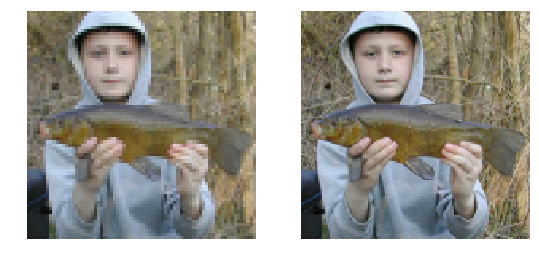

In [23]:
idx=1
fig,axes = plt.subplots(1,2,figsize=(9,5))
show_img(x,idx, ax=axes[0])
show_img(y,idx, ax=axes[1])

using same image in x and y, we pass through transformation to make y a higher resolution 288x288 while x remains at 72. hr = lr *4 here

In [24]:
batches = [next(iter(md.aug_dl)) for i in range(9)]

In [25]:
idx=1

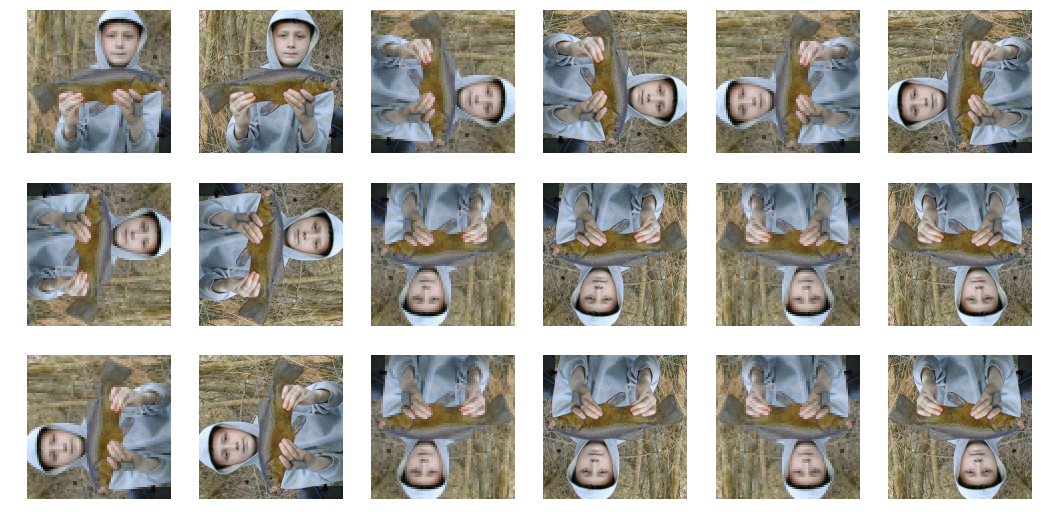

In [26]:
fig, axes = plt.subplots(3,6, figsize=(18,9))
for i,(x,y) in enumerate(batches):
    show_img(x,idx, ax=axes.flat[i*2]) #*2 is used to skip 2 each time as x and y is layed out
    show_img(y,idx, ax=axes.flat[i*2+1])

## Model

In [27]:
def conv(ni, nf, kernel_size=3, actn=False):
    layers = [nn.Conv2d(ni, nf, kernel_size, padding=kernel_size//2)]
    if actn: layers.append(nn.ReLU(True))
    return nn.Sequential(*layers)

In [28]:
class ResSequential(nn.Module):
    def __init__(self, layers, res_scale=1.0):
        super().__init__()
        self.res_scale = res_scale
        self.m = nn.Sequential(*layers)
        
    def forward(self, x): return x + self.m(x) * self.res_scale

In [29]:
def res_block(nf):
    return ResSequential(
        [conv(nf,nf, actn=True), conv(nf,nf)],
        0.1)

In [30]:
def upsample(ni, nf, scale):
    layers = []
    for i in range(int(math.log(scale,2))):
        layers += [conv(ni, nf*4), nn.PixelShuffle(2)]
    return nn.Sequential(*layers)

In [31]:
class SrResnet(nn.Module):
    def __init__(self, nf, scale):
        super().__init__()
        features = [conv(3,64)]
        for i in range(8): features.append(res_block(64))
        features += [conv(64,64), upsample(64,64,scale),
                     nn.BatchNorm2d(64),
                     conv(64,3)]
        self.features = nn.Sequential(*features)
        
    def forward(self, x): return self.features(x)

## Pixel loss

In [32]:
m = to_gpu(SrResnet(64, scale))
# if you have more than one GPU, list the GPU ids below
# m = nn.DataParallel(m, [0,1])
m = nn.DataParallel(m, [0])

learn = Learner(md, SingleModel(m), opt_fn = optim.Adam)
learn.crit = F.mse_loss

 24%|██▍       | 4748/19819 [17:03<54:08,  4.64it/s, loss=0.206]   

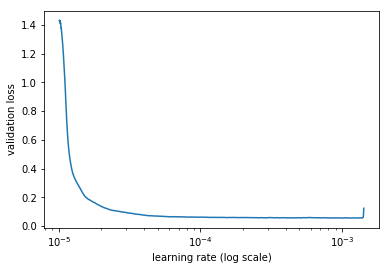

In [175]:
learn.lr_find(start_lr=1e-5, end_lr=10000)
learn.sched.plot()

In [183]:
lr=2e-3

In [184]:
learn.fit(lr,1,cycle_len=1,use_clr_beta=(40,10))

epoch      trn_loss   val_loss                                      
    0      0.05242    0.046641  


[0.04664120597478569]

In [185]:
x,y = next(iter(md.val_dl))
preds = learn.model(VV(x))

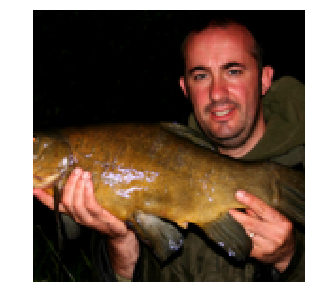

In [186]:
idx = 3
show_img(y,idx)

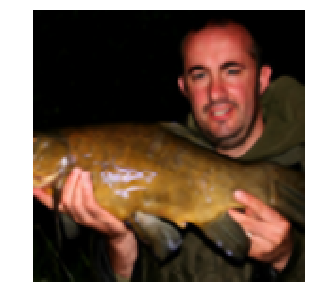

In [187]:
show_img(preds, idx)

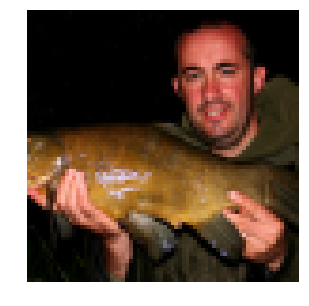

In [188]:
show_img(x,idx)

In [189]:
x,y = next(iter(md.val_dl))
preds =  learn.model(VV(x))

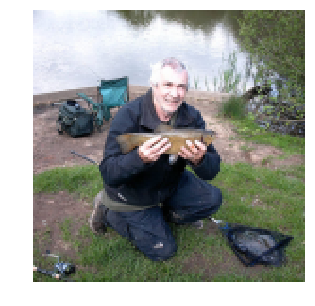

In [192]:
show_img(y,idx+3)

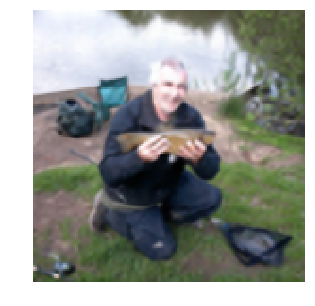

In [193]:
show_img(preds,idx+3)

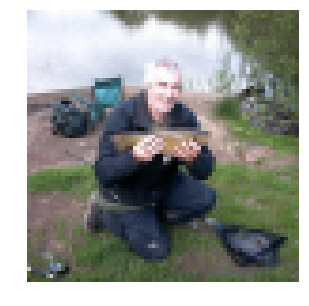

In [194]:
show_img(x,idx+3)

In [195]:
learn.save('sr-samp0')

In [33]:
learn.load('sr-samp0')

## Pereptual loss

In [34]:
def icnr(x, scale=2, init=nn.init.kaiming_normal):
    new_shape = [int(x.shape[0] / (scale ** 2))] + list(x.shape[1:])
    subkernel = torch.zeros(new_shape)
    subkernel = init(subkernel)
    subkernel = subkernel.transpose(0,1)
    subkernel = subkernel.contiguous().view(subkernel.shape[0], subkernel.shape[1], -1)
    kernel = subkernel.repeat(1,1, scale ** 2)
    transposed_shape = [x.shape[1]] + [x.shape[0]] + list(x.shape[2:])
    kernel = kernel.contiguous().view(transposed_shape)
    kernel = kernel.transpose(0,1)
    return kernel

In [35]:
m_vgg = vgg16(True)

blocks = [i-1 for i,o in enumerate(children(m_vgg))
                 if isinstance(o,nn.MaxPool2d)]
blocks, [m_vgg[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [36]:
vgg_layers = children(m_vgg)[:23]
m_vgg = nn.Sequential(*vgg_layers).cuda().eval()
set_trainable(m_vgg, False)

In [37]:
def flatten(x): return x.view(x.size(0), -1)

In [38]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [39]:
class FeatureLoss(nn.Module):
    def __init__(self, m, layer_ids, layer_wgts):
        super().__init__()
        self.m, self.wgts = m, layer_wgts
        self.sfs = [SaveFeatures(m[i]) for i in layer_ids]
        
    def forward(self, input, target, sum_layers=True):
        self.m(VV(target.data))
        res = [F.l1_loss(input,target)/100]
        targ_feat = [ V(o.features.data.clone()) for o in self.sfs] 
        #clone since the data would change again for input x
        self.m(input)
        res += [F.l1_loss(flatten(inp.features), flatten(targ))*wgt
                for inp,targ,wgt in zip(self.sfs, targ_feat, self.wgts)]
        if sum_layers: res = sum(res)
        return res
    
    def close(self):
        for o in self.sfs: o.remove()

In [40]:
m = SrResnet(64, scale)

In [43]:
conv_shuffle = m.features[10][0][0]
kernel = icnr(conv_shuffle.weight, scale=scale)
conv_shuffle.weight.data.copy_(kernel);

In [44]:
m = to_gpu(m)

In [45]:
learn = Learner(md, SingleModel(m), opt_fn=optim.Adam)

In [46]:
t = torch.load(learn.get_model_path('sr-samp0'), map_location=lambda storage, loc:storage)
learn.model.load_state_dict(t,strict=False)

In [47]:
learn.freeze_to(999)

In [48]:
for i in range(10,13): set_trainable(m.features[i], True)

In [49]:
conv_shuffle =  m.features[10][0][0]
kernel = icnr(conv_shuffle.weight, scale=scale)
conv_shuffle.weight.data.copy_(kernel);

In [50]:
learn.crit = FeatureLoss(m_vgg, blocks[:3], [0.2,0.7,0.1])

In [51]:
lr=6e-3
wd=1e-7

In [52]:
learn.lr_find(1e-4,0.1, wds=wd, linear=True)

epoch      trn_loss   val_loss                                        
    0      0.060664   0.064664  



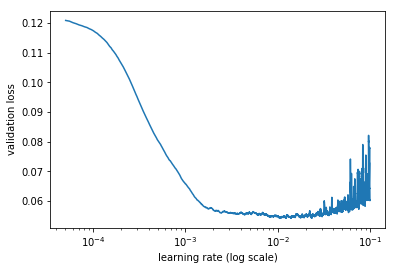

In [53]:
learn.sched.plot(n_skip_end=1)

In [54]:
learn.fit(lr,1,cycle_len=2, wds=wd, use_clr=(20,10))

epoch      trn_loss   val_loss                                        
    0      0.052772   0.049863  
    1      0.05321    0.049677                                        



[0.0496765487300234]

In [55]:
learn.save('sr-samp0')